In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import jax.numpy as jnp
import jax
from stl_team_game.specifications import get_reach_avoid_two_team_formula_cfmjx
from stl_team_game.env.mjx import make_env
from stl_team_game.env.mjx.utils import batchify, unbatchify

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [3]:
env = make_env("crazyflie_4_4_motor_1000_random_0.01_v0")

In [4]:
num_env = 10
rng = jax.random.key(0)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, num_env)

obsv, env_state = jax.vmap(env.reset)(reset_rng)

In [5]:
obs_boxes = env.get_obs_boxes(env_state.data)
goal_boxes = env.get_goal_boxes(env_state.data)

In [6]:
ego_stl_f, opp_stl_f = get_reach_avoid_two_team_formula_cfmjx(obs_boxes, goal_boxes, 100, 4, 4, 0.1, 2.0)

In [7]:
def _env_step(runner, unused):
    last_obs, env_state, rng = runner
    rng, _rng, _rng2 = jax.random.split(rng, 3)
    step_rng = jax.random.split(_rng, num_env)
    # action_rng = jax.random.split(_rng2, num_env*env.num_agents).reshape((env.num_agents, num_env, -1))
    actions_batch = jnp.zeros((num_env*env.num_agents, env.action_space(env.agents[0]).shape[0]))
    actions = unbatchify(actions_batch, env.agents, num_env, env.num_agents)
    ego_actions = batchify(actions, env.good_agents, env.num_good_agents*num_env)
    ego_obs_batch = batchify(last_obs, env.good_agents, env.num_good_agents*num_env)
    # actions = {a: jax.vmap(env.action_space(a).sample)(action_rng[i].squeeze()) for i, a in enumerate(env.agents)}
    obsv, env_state, r, d, i = jax.vmap(env.step)(step_rng, env_state, actions)
    ego_dones_batch = batchify(d, env.good_agents, env.num_good_agents*num_env)
    return (obsv, env_state, rng), (obsv, ego_actions, ego_obs_batch, ego_dones_batch, d["__all__"])

In [8]:
_, ret_traj = jax.lax.scan(_env_step, (obsv, env_state, rng), None, length=1000)

In [9]:
obs_traj, ego_actions_traj, ego_obs_traj, ego_done_traj, all_done_traj = ret_traj

In [10]:
all_traj = jnp.concatenate([obs_traj[a][:, :, 0:3] for a in env.agents], axis=-1)  # (time, env, num_agents*3)

In [11]:
all_traj = jnp.swapaxes(all_traj, 0, 1)  # (batch, time, num_agents*3)
all_traj.shape

(10, 1000, 24)

In [12]:
ego_robustness = jax.vmap(ego_stl_f.robustness)(all_traj)

/root/stl_team_game/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/root/stl_team_game/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated

In [13]:
ego_robustness_grad_fn = jax.grad(ego_stl_f.robustness)

In [14]:
grad_0 = jax.vmap(ego_robustness_grad_fn)(all_traj)

In [15]:
jnp.isnan(grad_0).any()

Array(False, dtype=bool)

In [16]:
test_grad = grad_0[0]
test_traj = all_traj[0]

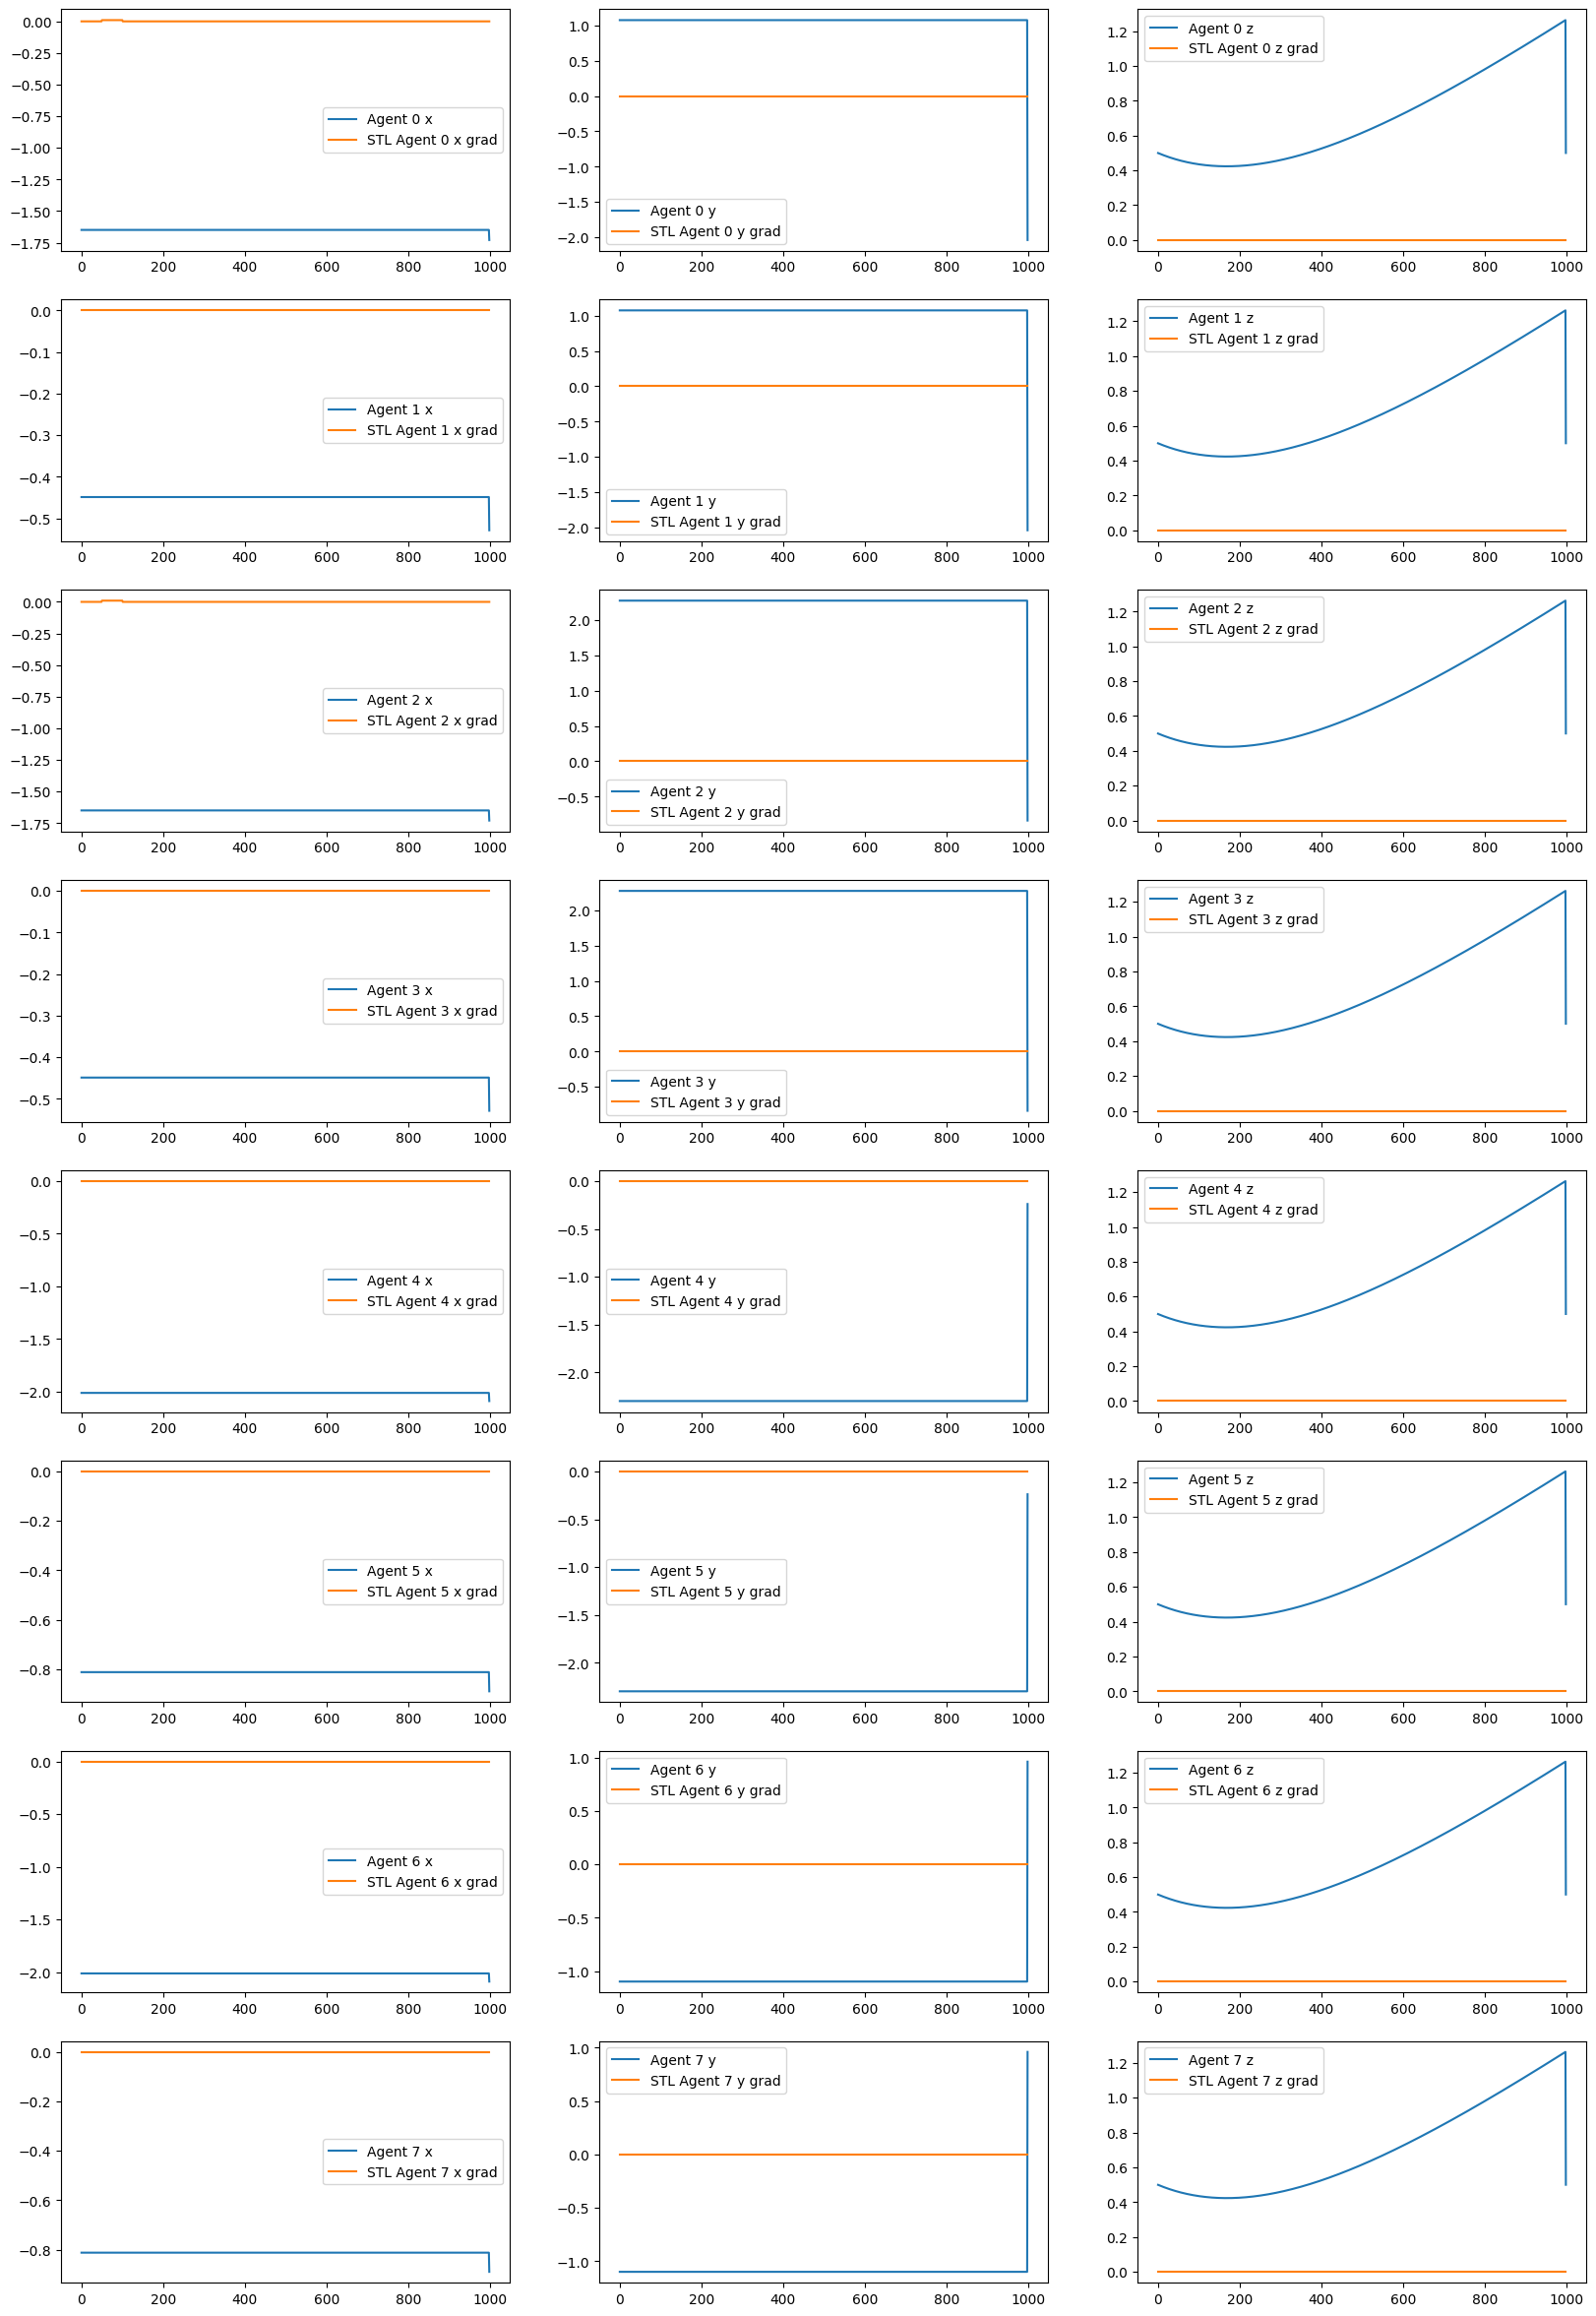

In [17]:
import matplotlib.pyplot as plt
# 24 states in traj: x,y,z for 8 agents
fig, axs = plt.subplots(8, 3, figsize=(20, 30))

for i in range(8):
    axs[i, 0].plot(test_traj[:, i*3 + 0], label=f'Agent {i} x')
    axs[i, 0].plot(test_grad[:, i*3 + 0], label=f'STL Agent {i} x grad')
    axs[i, 1].plot(test_traj[:, i*3 + 1], label=f'Agent {i} y')
    axs[i, 1].plot(test_grad[:, i*3 + 1], label=f'STL Agent {i} y grad')
    axs[i, 2].plot(test_traj[:, i*3 + 2], label=f'Agent {i} z')
    axs[i, 2].plot(test_grad[:, i*3 + 2], label=f'STL Agent {i} z grad')
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 2].legend()

In [20]:
from stl_team_game.models import RecurrentAgent, load_params
from stl_team_game.simple_dynamics import quadrotor
from stl_team_game.specifications import get_reach_avoid_two_team_formula_3d
from stl_team_game.utils.obs_helper import get_ego_obs, get_opp_obs, get_obs_sizes
from stl_team_game.scripts.main_jax_joint_moreobs import TrainConfig

In [34]:
config = TrainConfig()
ego_obs_size, opp_obs_size = get_obs_sizes(config)
policy_ego = RecurrentAgent(
    config.lstm_hidden_dim,
    config.control_dim,
    config.action_limit_high,
    config.action_limit_low,
    deterministic=True,
    scale_output=config.scale_output,
    scale=config.scale,
    normalize=config.normalize,
    final_activation=config.activation,
)
policy_opp = RecurrentAgent(
    config.lstm_hidden_dim,
    config.control_dim,
    config.action_limit_high,
    config.action_limit_low,
    deterministic=True,
    scale_output=config.scale_output,
    scale=config.scale,
    normalize=config.normalize,
    final_activation=config.activation,
)
policy_ego_params = load_params("/root/stl_team_game/src/stl_team_game/scripts/trained_models_joint/4090_crazyflie_wobs_biggergoals_lesssteps_moreepochs/ego_br_policy_step_29.safetensors")
policy_opp_params = load_params("/root/stl_team_game/src/stl_team_game/scripts/trained_models_joint/4090_crazyflie_wobs_biggergoals_lesssteps_moreepochs/opp_br_policy_step_29.safetensors")
ego_init_h = policy_ego.initialize_carry(config.num_ego * num_env, config.lstm_hidden_dim)
ego_init_h = jax.tree.map(lambda x: x.reshape((config.num_ego, num_env, config.lstm_hidden_dim)), ego_init_h)
opp_init_h = policy_opp.initialize_carry(config.num_opp * num_env, config.lstm_hidden_dim)
opp_init_h = jax.tree.map(lambda x: x.reshape((config.num_opp, num_env, config.lstm_hidden_dim)), opp_init_h)

In [35]:
rng = jax.random.key(config.seed)
rng, rng_start_ego, rng_start_opp = jax.random.split(rng, 3)
ego_start = jax.random.uniform(
    rng_start_ego,
    (config.num_ego, num_env, 3),
    minval=jnp.array(
        [
            config.ego_start_zone[0],
            config.ego_start_zone[2],
            config.ego_start_zone[4],
        ]
    ),
    maxval=jnp.array(
        [
            config.ego_start_zone[1],
            config.ego_start_zone[3],
            config.ego_start_zone[5],
        ]
    ),
)
opp_start = jax.random.uniform(
    rng_start_opp,
    (config.num_opp, num_env, 3),
    minval=jnp.array(
        [
            config.opp_start_zone[0],
            config.opp_start_zone[2],
            config.opp_start_zone[4],
        ]
    ),
    maxval=jnp.array(
        [
            config.opp_start_zone[1],
            config.opp_start_zone[3],
            config.opp_start_zone[5],
        ]
    ),
)
ego_initial_state = jnp.concatenate(
    (
        ego_start,
        jnp.zeros(
            (
                config.num_ego,
                num_env,
                config.state_dim - 3,
            )
        ),
    ),
    axis=-1,
)
opp_initial_state = jnp.concatenate(
    (
        opp_start,
        jnp.zeros(
            (
                config.num_opp,
                num_env,
                config.state_dim - 3,
            )
        ),
    ),
    axis=-1,
)

In [30]:
dyn_fn = jax.vmap(quadrotor, in_axes=(0, 0))
estl_f, ostl_f = get_reach_avoid_two_team_formula_3d(
    config.obs,
    config.goals,
    config.T,
    config.zone_1,
    config.zone_2,
    config.altitude1,
    config.altitude2,
    config.num_ego,
    config.num_opp,
)

In [37]:
def _env_step(runner, unused):
    (state, e_hidden, o_hidden) = runner
    ego_obs = get_ego_obs(state, config.num_ego, config.goals, config.obs)
    ego_control, e_hidden = policy_ego.apply(
        policy_ego_params,
        e_hidden,
        ego_obs,
    )
    opp_obs = get_opp_obs(state, config.num_ego, config.num_opp, config.goals, config.obs)
    opp_control, o_hidden = policy_opp.apply(
        policy_opp_params,
        o_hidden,
        opp_obs,
    )
    ego_next_state = dyn_fn(state[: config.num_ego, :, :], ego_control)
    opp_next_state = dyn_fn(state[config.num_ego :, :, :], opp_control)
    next_state = jnp.concatenate((ego_next_state, opp_next_state), axis=0).squeeze()
    return (next_state, e_hidden, o_hidden), next_state


_, eval_traj = jax.lax.scan(
    _env_step,
    (
        jnp.concatenate((ego_initial_state, opp_initial_state), axis=0),
        ego_init_h,
        opp_init_h,
    ),
    None,
    length=config.num_steps,
)
eval_traj = jnp.transpose(eval_traj, (2, 0, 1, 3))
eval_traj = eval_traj.reshape(eval_traj.shape[0], eval_traj.shape[1], -1)

In [ ]:
e_r = jax.vmap(estl_f.robustness)(eval_traj)
o_r = jax.vmap(ostl_f.robustness)(eval_traj)

 ,,,,., = jax.vmap(jax.grad(estl_f.robustness))(eval_traj)
o_r_grad = jax.vmap(jax.grad(ostl_f.robustness))(eval_traj)

In [60]:
plot_traj = eval_traj[0]
plot_grad = e_r_grad[0]

In [59]:
(e_r[0], o_r[0])

(Array(-0.06095056, dtype=float32), Array(0.06095056, dtype=float32))

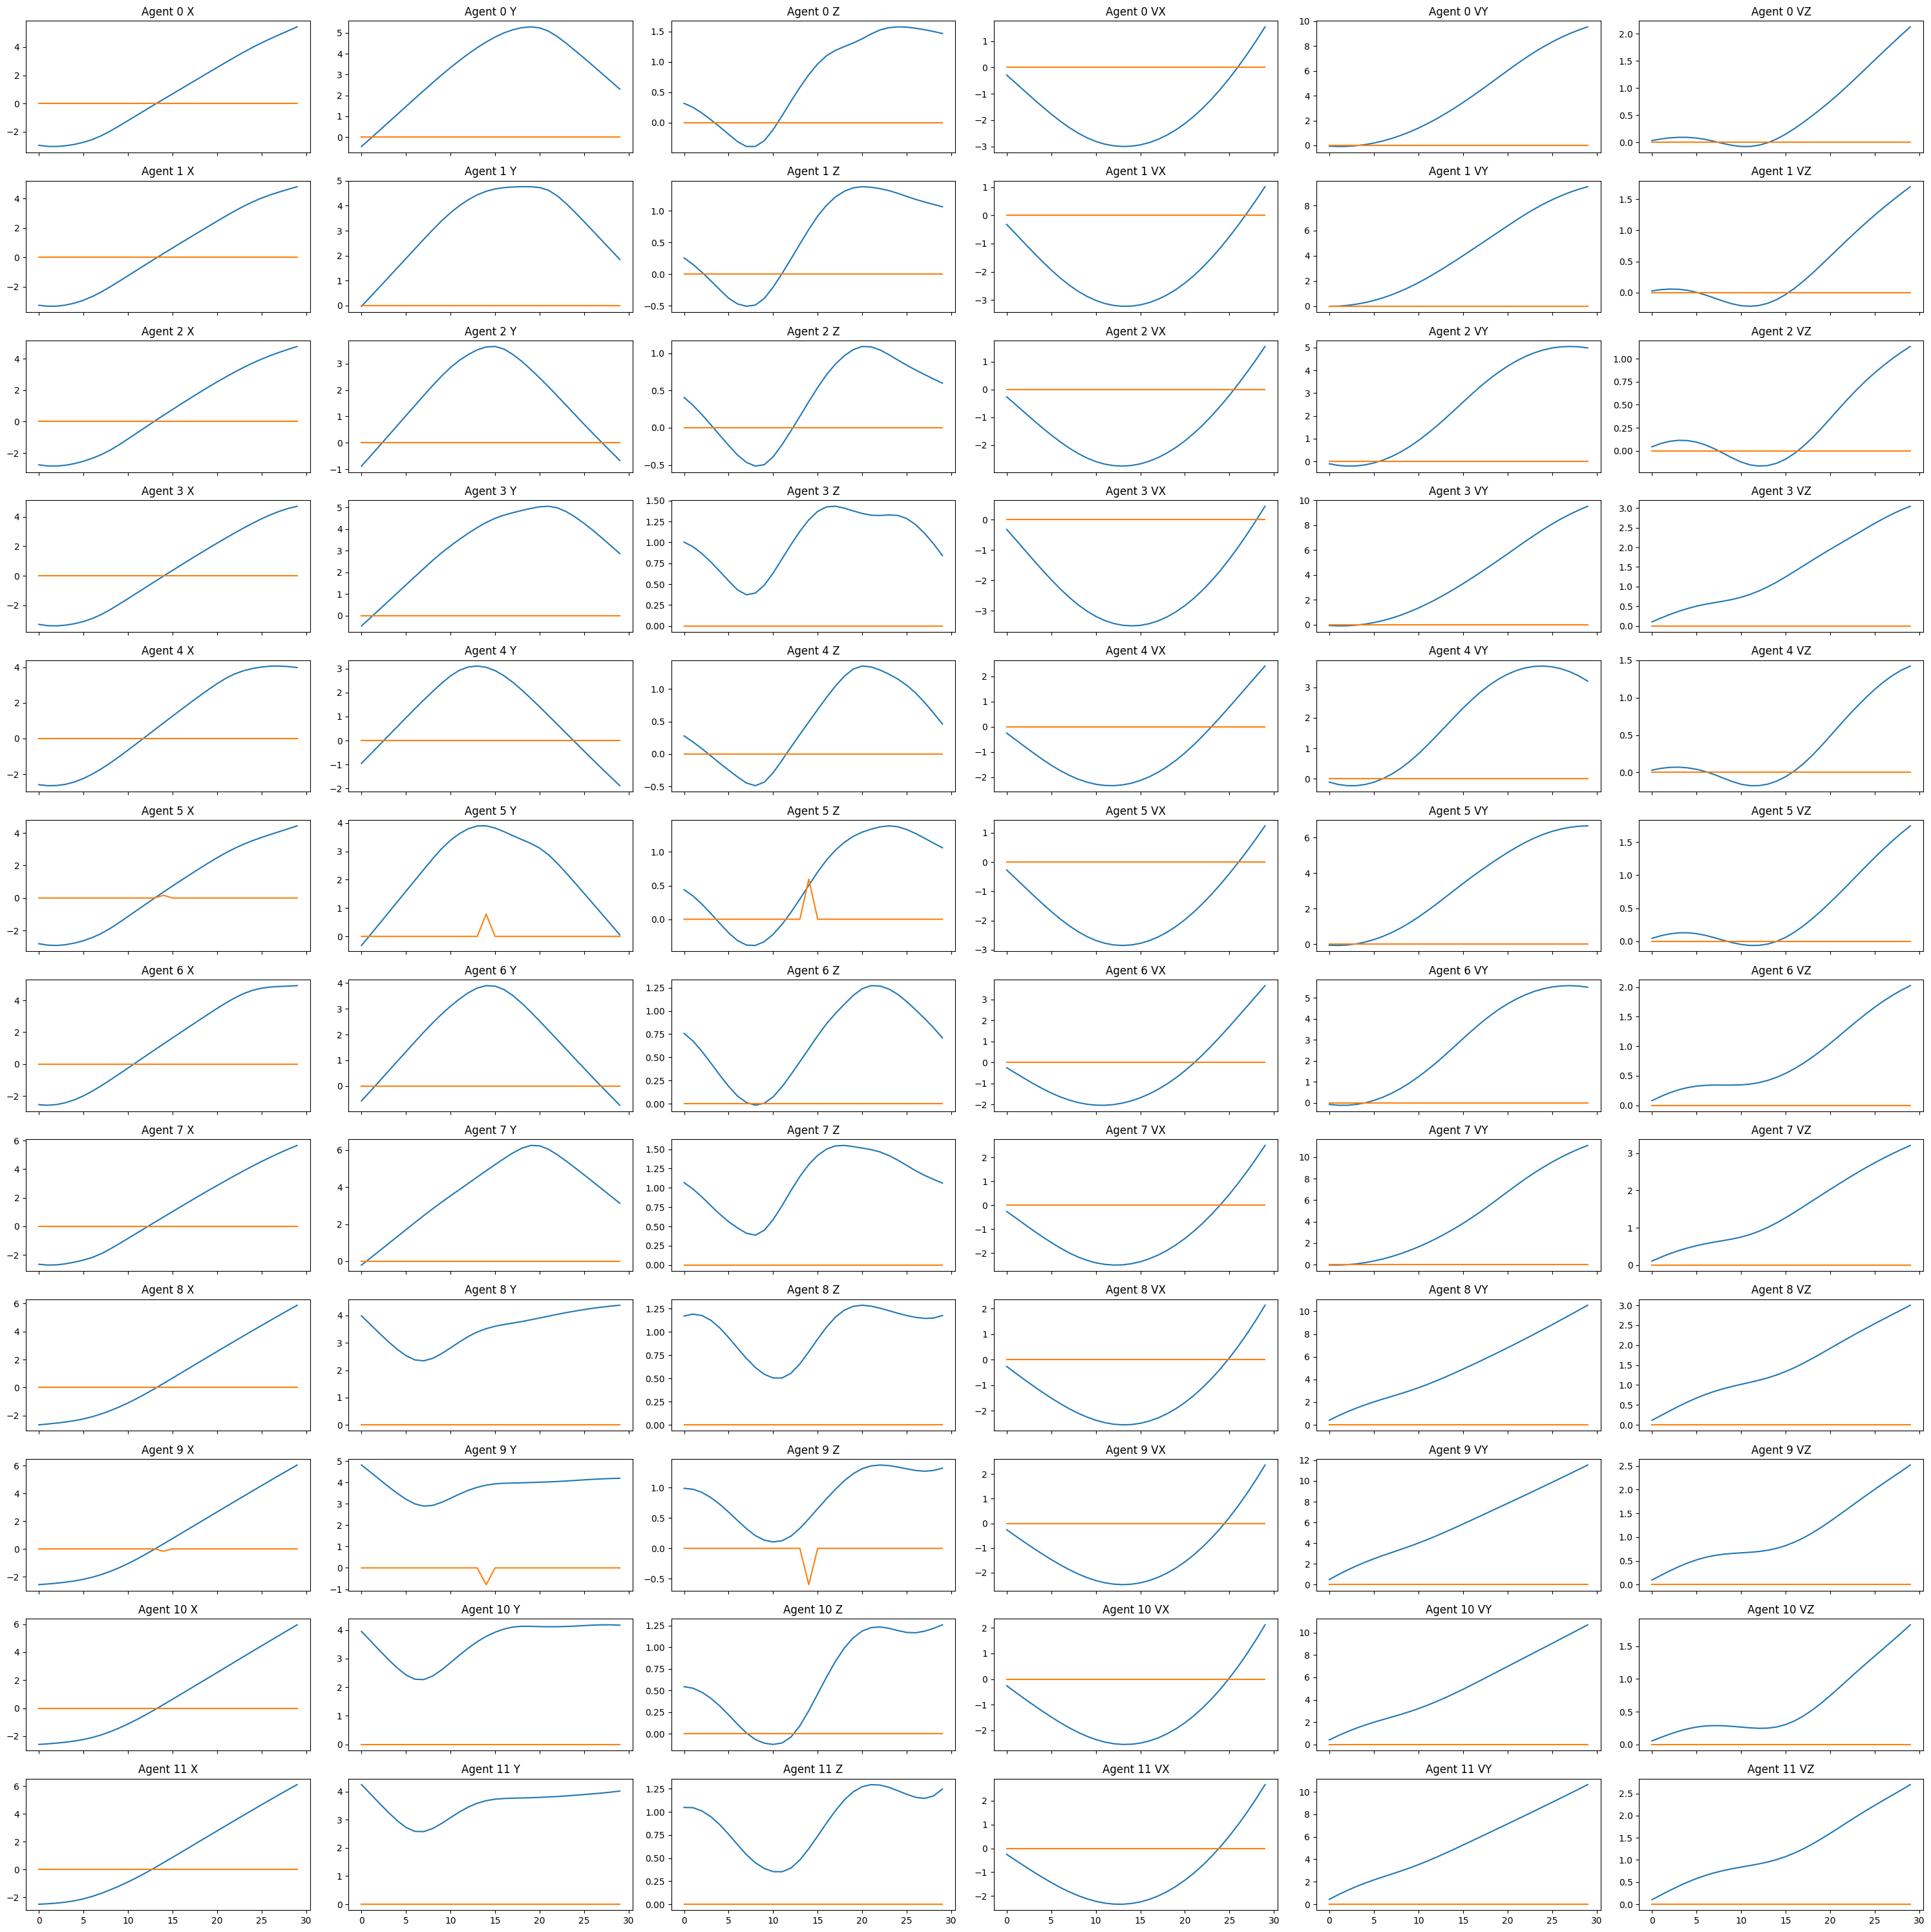

In [61]:
import matplotlib.pyplot as plt
# 72 states in traj: x,y,z,vx,vy,vz for 12 agents
fig, axs = plt.subplots(12, 6, figsize=(30, 30), dpi=100, sharex=True)

for i in range(12):
    axs[i, 0].plot(plot_traj[:, i*6 + 0], label=f'Agent {i} x')
    axs[i, 0].plot(plot_grad[:, i*6 + 0], label=f'STL Agent {i} x grad')
    axs[i, 1].plot(plot_traj[:, i*6 + 1], label=f'Agent {i} y')
    axs[i, 1].plot(plot_grad[:, i*6 + 1], label=f'STL Agent {i} y grad')
    axs[i, 2].plot(plot_traj[:, i*6 + 2], label=f'Agent {i} z')
    axs[i, 2].plot(plot_grad[:, i*6 + 2], label=f'STL Agent {i} z grad')
    axs[i, 3].plot(plot_traj[:, i*6 + 3], label=f'Agent {i} vx')
    axs[i, 3].plot(plot_grad[:, i*6 + 3], label=f'STL Agent {i} vx grad')
    axs[i, 4].plot(plot_traj[:, i*6 + 4], label=f'Agent {i} vy')
    axs[i, 4].plot(plot_grad[:, i*6 + 4], label=f'STL Agent {i} vy grad')
    axs[i, 5].plot(plot_traj[:, i*6 + 5], label=f'Agent {i} vz')
    axs[i, 5].plot(plot_grad[:, i*6 + 5], label=f'STL Agent {i} vz grad')
    # axs[i, 0].legend()
    axs[i, 0].set_title(f'Agent {i} X')
    axs[i, 1].set_title(f'Agent {i} Y')
    axs[i, 2].set_title(f'Agent {i} Z')
    axs[i, 3].set_title(f'Agent {i} VX')
    axs[i, 4].set_title(f'Agent {i} VY')
    axs[i, 5].set_title(f'Agent {i} VZ')
plt.tight_layout()

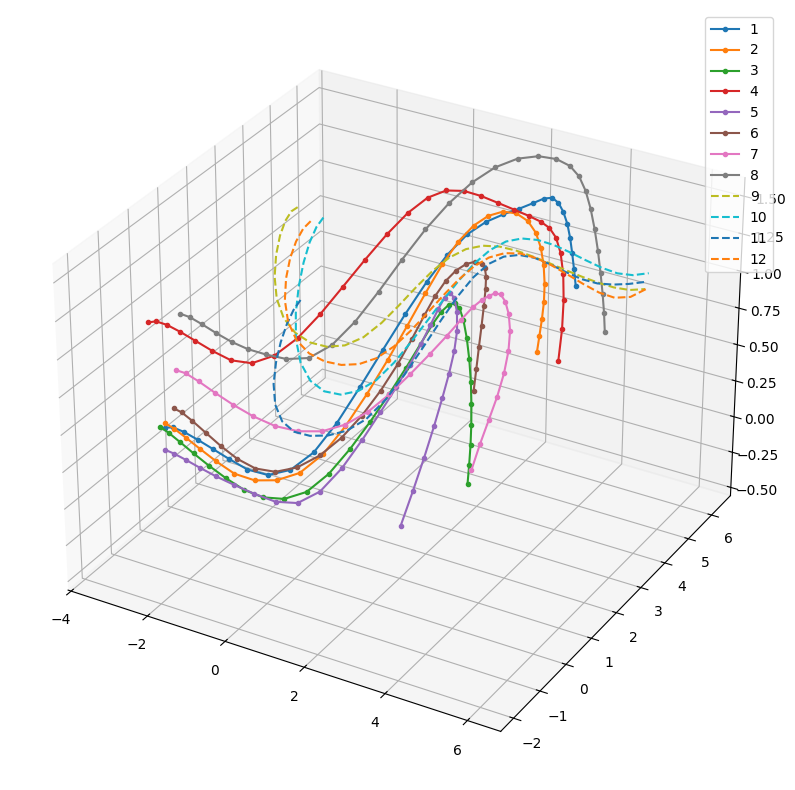

In [79]:
# switch to 3d plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = plt.subplot(projection='3d')

ax.plot(plot_traj[:, 0], plot_traj[:, 1], plot_traj[:, 2], marker=".", label="1")
ax.plot(plot_traj[:, 6], plot_traj[:, 7], plot_traj[:, 8], marker=".", label="2")
ax.plot(plot_traj[:, 12], plot_traj[:, 13], plot_traj[:, 14], marker=".", label="3")
ax.plot(plot_traj[:, 18], plot_traj[:, 19], plot_traj[:, 20], marker=".", label="4")
ax.plot(plot_traj[:, 24], plot_traj[:, 25], plot_traj[:, 26], marker=".", label="5")
ax.plot(plot_traj[:, 30], plot_traj[:, 31], plot_traj[:, 32], marker=".", label="6")
ax.plot(plot_traj[:, 36], plot_traj[:, 37], plot_traj[:, 38], marker=".", label="7")
ax.plot(plot_traj[:, 42], plot_traj[:, 43], plot_traj[:, 44], marker=".", label="8")
ax.plot(plot_traj[:, 48], plot_traj[:, 49], plot_traj[:, 50], "--", label="9")
ax.plot(plot_traj[:, 54], plot_traj[:, 55], plot_traj[:, 56], "--", label="10")
ax.plot(plot_traj[:, 60], plot_traj[:, 61], plot_traj[:, 62], "--", label="11")
ax.plot(plot_traj[:, 66], plot_traj[:, 67], plot_traj[:, 68], "--", label="12")
ax.legend()